In [1]:
%reset-f
%load_ext autoreload
%autoreload
%matplotlib inline

import pandas as pd
import numpy as np
import statsmodels.formula.api as sm

import warnings
warnings.filterwarnings("always",category=UserWarning)
from res_ind_lib import *
import os, time
import itertools

from wb_api_wraper import *
from progress_reporter import *
from sorted_nicely import *

### WB data

In [2]:
#population from WB (to check popluation from Landscan)
pop      =get_wb_mrv('SP.POP.TOTL'      ,"pop").squeeze()#population

C:\Users\Admin\Anaconda3\lib\site-packages\pandas_datareader\wb.py:159: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  out = out.convert_objects(convert_numeric=True)


In [3]:
#country dictionaries
iso_country = pd.read_csv("iso3_to_wb_name.csv", index_col = "iso3", squeeze=True)
name_wb_name = pd.read_csv("any_name_to_wb_name.csv",index_col="any",squeeze=True)

### population from landscan

In [4]:
#total pop from landscan
h=pd.read_csv("pop_landscan_0703.csv")
h.columns = h.columns.str.lower()
h["country"]=h.admin.replace(name_wb_name)
pop_landscan = h.rename(columns=dict(pylssum="pop")).dropna().set_index("country")["pop"] 

country
Angola                            0.743590
Aruba                             0.725486
Bahamas, The                      0.741104
Bahrain                           0.739369
Comoros                           0.796239
Cyprus                            0.590169
Equatorial Guinea                 0.708032
Faeroe Islands                    0.737417
French Polynesia                  0.685561
Greenland                         0.303881
Kiribati                          0.229800
Kuwait                            0.701714
Maldives                          0.322746
Marshall Islands                  0.075617
Norway                            0.788198
Oman                              0.719515
Palau                             0.667109
Papua New Guinea                  0.796226
Samoa                             0.752008
Solomon Islands                   0.604788
Somalia                           0.713505
St. Kitts and Nevis               0.699658
St. Vincent and the Grenadines    0.666789
Ton

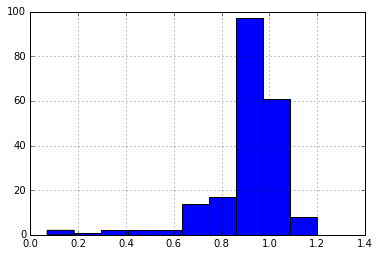

In [5]:
#compares population in landscan with population in WB
test=(pop_landscan/pop)
test.hist()
test[test<.8]

### Data on exposure per bassin per country per hydro return period

In [6]:
# adapts chaging raw data to current code
translator ={'iso_a3':"country_iso", "fpu_id":"fpu_id", 'lssum':'fpu_population', 'py5sum':"5", 'py10sum':"10",
        'py25sum':"25",  'py50sum':"50",  'py100sum':"100", 'py250sum':"250",  'py500sum':"500",  'py1000sum':"1000",
        'admin':'name'}
#Reads data on exposure per bassin per country per hydro return period prepared by Mook for me
ebp=pd.read_csv("basins_0702_adrien.csv")
#translates random column names to what i want to use
ebp.columns=ebp.columns.str.lower()
ebp =ebp.rename(columns=translator)[sorted_nicely(list(translator.values()))];

ebp.head()

,5,10,25,50,100,250,500,1000,country_iso,fpu_id,fpu_population,name
0,0,0,0,0,0,0,0,0,AFG,20,472,Afghanistan
1,34094,73400,102266,104100,105534,105828,116724,117383,AFG,172,2791282,Afghanistan
2,322025,461759,539858,565776,599214,635334,651817,680372,AFG,188,7392882,Afghanistan
3,47,74,1243,1364,1364,4447,4854,4854,AFG,205,135807,Afghanistan
4,1659,1798,1907,2256,2275,2499,2754,2905,AFG,206,21637,Afghanistan


In [7]:
ebp["country"] = ebp.name.replace(name_wb_name)
print("Places for which we have data on exposure per bassin and return period that I ignored:\n"+", ".join([str(c) for c in ebp.country.unique() if c not in iso_country.unique()]+list(ebp.ix[ebp.country.isnull()].name.unique())))
ebp= ebp.dropna()

Places for which we have data on exposure per bassin and return period that I ignored:
Akrotiri Sovereign Base Area, nan, Baykonur Cosmodrome, Cura̤ao, Cyprus No Mans Area, Dhekelia Sovereign Base Area, Kosovo, Northern Cyprus, Palestine, São Tomé and Príncipe, Siachen Glacier, Somaliland, US Naval Base Guantanamo Bay, Aland, Falkland Islands, Gibraltar, Guernsey, Jersey, Montserrat, Saint Pierre and Miquelon, Vatican, Western Sahara


### index by country,bassin

In [8]:
#Reshaping

#return periods
col_names = {'5':5, '10':10, '25':25, '50':50, '100':100, '250':250, '500':500, '1000':1000}
p = sorted(list(col_names.values()))  # return periods 

#reshaping
expo_bassin = ebp.set_index(["country","fpu_id"]).drop(["country_iso","name"],axis=1).sortlevel().rename(columns=col_names)

#separates exposure and total population
pop_bassin_country = expo_bassin["fpu_population"]
expo_bassin = expo_bassin[p]

#Assumes nobody exposed under 5 years
expo_bassin[0]=expo_bassin[5]

#sort by increasing return period
expo_bassin.sort_index(axis=1,inplace=True)

#show number of people exposed in each country,bassin
expo_bassin.head()

0       5       10      25      50      100     250   \
country     fpu_id                                                           
Afghanistan 20           0       0       0       0       0       0       0   
            172      34094   34094   73400  102266  104100  105534  105828   
            188     322025  322025  461759  539858  565776  599214  635334   
            205         47      47      74    1243    1364    1364    4447   
            206       1659    1659    1798    1907    2256    2275    2499   

                      500     1000  
country     fpu_id                  
Afghanistan 20           0       0  
            172     116724  117383  
            188     651817  680372  
            205       4854    4854  
            206       2754    2905

Countries with missmatch between tot pop and bassin pop country
Aruba                       0.000021
St. Lucia                   0.525274
Turks and Caicos Islands    0.476926
Vanuatu                     0.892374
Virgin Islands, British     0.828344
dtype: float64 Series([], dtype: float64)


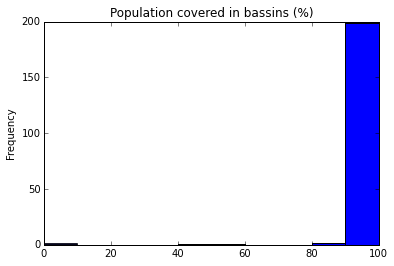

In [9]:
#Country population sanity check
check = (pop_bassin_country.sum(level="country")/pop_landscan)
(100*check).plot(kind="hist",title="Population covered in bassins (%)")
print("Countries with missmatch between tot pop and bassin pop",check[check<.9],check[check>1])
check.to_csv("pop_covered_bassins.csv")
del check

In [10]:
#Bassin population sanity check (same bassin should be different accross countries)
expo_bassin.reset_index().set_index("fpu_id").sort_index().head()

,country,0,5,10,25,50,100,250,500,1000
fpu_id,,,,,,,,,,
2,Greenland,0,0,0,0,0,0,0,0,0
3,Russian Federation,362,362,442,546,578,612,660,679,689
4,Russian Federation,3318,3318,4469,5036,5462,5705,6047,6217,6458
5,Canada,2520,2520,2556,3522,3862,4193,4193,4194,4856
5,United States,1364,1364,1603,1674,1793,1804,1848,1918,1930


### Simulates events

In [11]:
from scipy.interpolate import interp1d

In [12]:
#theory
q = [0]+[1-1/x for x in p]+[1]
q=pd.Series(np.diff(q),index=[0]+p)
print("probas\n",q)
print("Sum:",np.sum(q))

#using quantiles to compute return periods
quant = [1-1/x for x in p]
#quant[0]=0.805 #works around numerical bug with only one bassin
print("Quantiles:" ,quant)

probas
 0       0.800
5       0.100
10      0.060
25      0.020
50      0.010
100     0.006
250     0.002
500     0.001
1000    0.001
dtype: float64
Sum: 1.0
Quantiles: [0.8, 0.9, 0.96, 0.98, 0.99, 0.996, 0.998, 0.999]


In [13]:
result=pd.DataFrame(columns=ebp.country.unique(), index=quant)

In [15]:
#Number of simulations per (country, bassin) 
n=int(1e5)

#preallocating dataframe of result
result=pd.DataFrame(columns=ebp.country.unique(), index=quant)

for c in result.columns:#loop on return periods

    events = pd.DataFrame(index=range(0,n), columns=expo_bassin.ix[c].index).fillna(0)
    events.name="sce"
    for f in events.columns:#loop on bassins in the country
        
        progress_reporter((c,f))
        
        x=expo_bassin.ix[c,f]
        rand=np.power(np.random.random(n),-1) #rand is indipendent across bassins
        
        events[f]=interp1d(x.index,x, fill_value=x[1000], bounds_error=False)( rand)

    result[c] =(events.sum(axis=1)/pop_landscan.ix[c]).quantile(quant)

result = result.transpose()
result.index.name="country"
result.columns=p


('Zimbabwe', 399)


In [16]:
#Displays exposure computed per country and macro-level return period
result.head()

,5,10,25,50,100,250,500,1000
country,,,,,,,,
Afghanistan,0.071899,0.075261,0.080745,0.082926,0.085365,0.088709,0.090459,0.092220
Akrotiri Sovereign Base Area,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Albania,0.044355,0.061332,0.071366,0.072500,0.073680,0.074698,0.075410,0.077130
Algeria,0.028810,0.030041,0.032382,0.033731,0.034776,0.036066,0.036589,0.037308
Andorra,0.142611,0.146793,0.278119,0.280933,0.280933,0.293741,0.293741,0.293741


In [17]:
result.ix[["Denmark","Gabon","Poland"]]

,5,10,25,50,100,250,500,1000
country,,,,,,,,
Denmark,0.001399,0.004065,0.004228,0.005839,0.006072,0.006188,0.006294,0.006365
Gabon,0.070042,0.073553,0.078199,0.087377,0.093962,0.101445,0.106434,0.113108
Poland,0.037654,0.044625,0.051666,0.054686,0.057824,0.061600,0.064492,0.068328


In [24]:
if any(result[result==0].dropna(how="all").sum(axis=1)>0):
    raise Exception("There where some wrong simulations")

In [26]:
result.to_csv("exposure_econ_return_period.csv",encoding="utf-8")

### Comparing with previous, erroneous, method

In [27]:
result[result==0].dropna(how="all")  #make sure there is no line with 0 in the first column but no other column

,5,10,25,50,100,250,500,1000
country,,,,,,,,
Akrotiri Sovereign Base Area,0,0,0,0,0,0,0,0
Antigua and Barbuda,0,0,0,0,0,0,0,0
Aruba,0,0,0,0,0,0,0,0
Bahrain,0,0,0,0,0,0,0,0
Barbados,0,0,0,0,0,0,0,0
"Virgin Islands, British",0,0,0,0,0,0,0,0
Comoros,0,0,0,0,0,0,0,0
Cura̤ao,0,0,0,0,0,0,0,0
Cyprus,0,0,0,0,0,0,0,0


,0,5,10,25,50,100,250,500,1000
country,,,,,,,,,
Afghanistan,,1.1144,,,,,,,
Albania,,1.00432,1.00044,,,1.00014,,1.00113,
Algeria,,1.07741,,,,,,,
Andorra,,1.06437,,,,,,,
Angola,,1.02777,,,,,,,
Argentina,,1.09183,,,,,,,
Armenia,,,,,,,,1.00012,
Australia,,1.08297,,,,,,,
Austria,,1.13904,,,,,,,


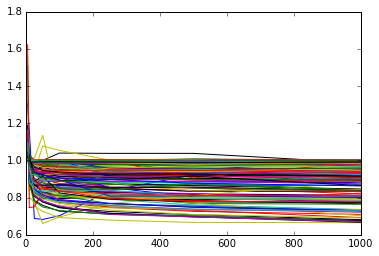

In [28]:
compare = result/(expo_bassin.sum(level="country").div(pop_landscan,axis=0))
compare.transpose().plot(legend=None)
compare[compare>1].dropna(how="all").fillna(" ")